# intro

test fitting 'strain' ringdown with multiple modes
and fitting amp and freq around the peak -/+ 10-30M

In [1]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 432x288 with 0 Axes>

In [2]:
import re
import glob
import os
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import numpy as np
import pandas as pd
import pathlib

In [3]:
import nr_utils

In [16]:
import lmfit

In [5]:
import scipy.optimize

In [ ]:
# sxs_list=[
#     # '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5',
#     # '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res3.h5'
#     '/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5',
# ]


In [7]:
    
#     "/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5", #q=2
#     "/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5", #q=10


In [8]:
lms = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5),(5,4)]

In [9]:
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
# nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
nrfile = "/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10
simname = nrfile.split('/')[-1].split('.h5')[0]
nrls = {}
for l, m in lms:
    nrls[l,m] = nr_utils.NRLoader(handler='nr_hdf5', nr_hdf5_filename=nrfile, dt=0.1, safety_factor=0.5, ell=l, mm=m)

In [10]:
nrls[(2,2)].q

9.999928005812196

In [11]:
nrls.keys()

dict_keys([(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3), (5, 5), (5, 4)])

In [12]:
nrls[2,1].times

array([-3398.82617388, -3398.72617388, -3398.62617388, ...,
         497.47382612,   497.57382612,   497.67382612])

In [13]:
nrls[2,1].strain

array([ 2.50072771e-03-2.53054203e-03j,  2.50680639e-03-2.52454264e-03j,
        2.51286780e-03-2.51852944e-03j, ...,
       -2.50057991e-06+1.20649143e-06j, -2.50253596e-06+1.20527118e-06j,
       -2.50458495e-06+1.20386135e-06j])

(-100.0, 100.0)

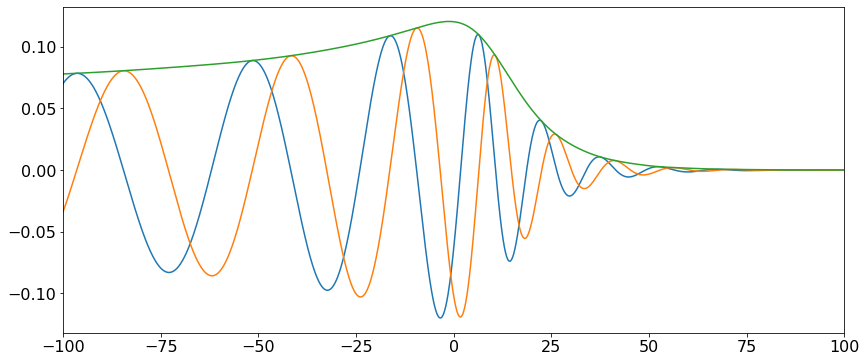

In [14]:
plt.figure(figsize=(14,6))
plt.plot(nrls[2,2].times, nrls[2,2].strain.real)
plt.plot(nrls[2,2].times, nrls[2,2].strain.imag)
plt.plot(nrls[2,2].times, np.abs(nrls[2,2].strain))
plt.xlim(-100,100)

(-100.0, 100.0)

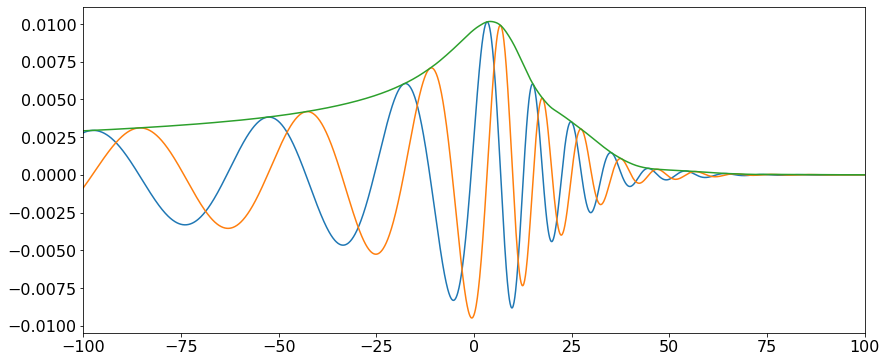

In [15]:
plt.figure(figsize=(14,6))
plt.plot(nrls[3,2].times, nrls[3,2].strain.real)
plt.plot(nrls[3,2].times, nrls[3,2].strain.imag)
plt.plot(nrls[3,2].times, np.abs(nrls[3,2].strain))
plt.xlim(-100,100)

## fitting

In [790]:
def resid_fn(params, x, ydata=None, use_sin=False):
    decay_22 = params['decay_22'].value
    phi0_22 = params['phi0_22'].value
    t0_22 = params['t0_22'].value
    omega_22 = params['omega_22'].value
    amp_22 = params['amp_22'].value
    
    decay_32 = params['decay_32'].value
    phi0_32 = params['phi0_32'].value
    t0_32 = params['t0_32'].value
    omega_32 = params['omega_32'].value
    amp_32 = params['amp_32'].value

    if use_sin:
        term_22 = amp_22 * np.exp(-(x-t0_22)/decay_22) * np.sin(x*omega_22 + phi0_22)
        term_32 = amp_32 * np.exp(-(x-t0_32)/decay_32) * np.sin(x*omega_32 + phi0_32)
        y_model = term_22 + term_32
    else:
        term_22 = amp_22 * np.exp(-(x-t0_22)/decay_22) * np.cos(x*omega_22 + phi0_22)
        term_32 = amp_32 * np.exp(-(x-t0_32)/decay_32) * np.cos(x*omega_32 + phi0_32)
        y_model = term_22 + term_32
    if type(ydata) == np.ndarray:
        return y_model - ydata
    else:
        return y_model

In [791]:
def fit(x, y, resid_fn):

    
    # f_ring = metadata.loc[idx]['fring']
    # f_damp = metadata.loc[idx]['fdamp']

    # q=1 numbers
    f_ring = 0.088087
    f_damp = 0.013596
    
    f_ring_angular = f_ring*2*np.pi
    f_damp_angular = f_damp*2*np.pi
    
    phi0_init = 1.0
    t0_init = 1.0
    amp_init = 0.5
    # omega_init = 0.5
    omega_22_init = f_ring_angular
    # decay_init = 17
    decay_22_init = 1/f_damp_angular

    omega_32_init = omega_22_init
    decay_32_init = decay_22_init




    # np.random.seed(2)
    # x = np.linspace(0, 10, 101)
    # y = offset + amp*np.sin(omega*x) * np.exp(-x/decay)
    # yn = y + np.random.normal(size=y.size, scale=0.450)

    params = lmfit.Parameters()
    params.add('phi0_22', phi0_init, min=-100, max=100.0)
    params.add('t0_22', t0_init, min=-100, max=100.0)
    params.add('omega_22', omega_22_init, min=0, max=100.0, vary=True)
    params.add('amp_22', amp_init, min=0, max=100.0)
    params.add('decay_22', decay_22_init, min=0, max=100.0, vary=True)

    params.add('phi0_32', phi0_init, min=-100, max=100.0)
    params.add('t0_32', t0_init, min=-100, max=100.0)
    params.add('omega_32', omega_32_init, min=0, max=100.0, vary=True)
    params.add('amp_32', amp_init, min=0, max=100.0)
    params.add('decay_32', decay_32_init, min=0, max=100.0, vary=True)
    o1 = lmfit.minimize(resid_fn, params, args=(x, y), method='leastsq')
    print("# Fit using leastsq:")
    lmfit.report_fit(o1)
    
    return o1

In [792]:
x = nrls[3,2].times
y = nrls[3,2].strain.real
y_im = nrls[3,2].strain.imag
x_start = 25
x_end = 100
mask_fit = (x >= x_start) & (x <= x_end)

x_fit = x[mask_fit]
y_fit = y[mask_fit]

o1 = fit(x_fit, y_fit, resid_fn)

# Fit using leastsq:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 415
    # data points      = 750
    # variables        = 10
    chi-square         = 1.0477e-08
    reduced chi-square = 1.4158e-11
    Akaike info crit   = -18725.6255
    Bayesian info crit = -18679.4248
[[Variables]]
    phi0_22:   3.26407843 +/- 0.01263837 (0.39%) (init = 1)
    t0_22:    -96.3333733 +/- 10941.1902 (11357.63%) (init = 1)
    omega_22:  0.41770751 +/- 3.4893e-04 (0.08%) (init = 0.5534669)
    amp_22:    48.8442861 +/- 49050.0869 (100421.34%) (init = 0.5)
    decay_22:  10.8952905 +/- 0.03715801 (0.34%) (init = 11.70601)
    phi0_32:  -3.76151772 +/- 0.00231846 (0.06%) (init = 1)
    t0_32:    -81.8563780 +/- 3114.20780 (3804.48%) (init = 1)
    omega_32:  0.64500535 +/- 6.4720e-05 (0.01%) (init = 0.5534669)
    amp_32:    50.4328426 +/- 14184.3343 (28125.19%) (init = 0.5)
    decay_32:  11.0726555 +/- 0.00892700 (0.08%) (init = 11.70601)
[[Correlations]] (unreported co

In [793]:
o1

In [794]:
yhat_re = resid_fn(o1.params, x_fit)
yhat_im = resid_fn(o1.params, x_fit, use_sin=True)

(-10.0, 100.0)

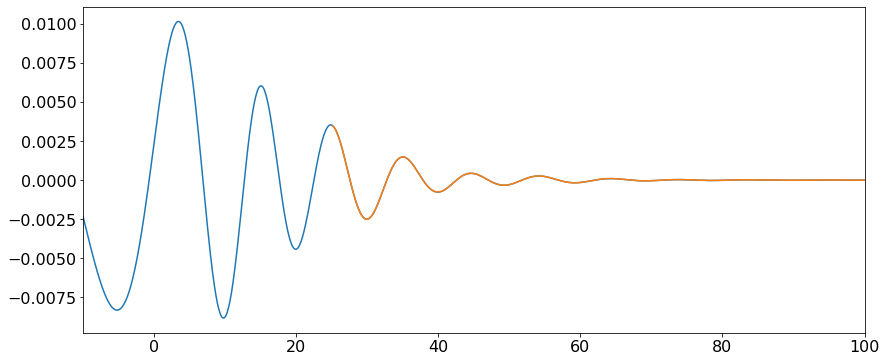

In [795]:
plt.figure(figsize=(14,6))
plt.plot(x, y)
plt.plot(x_fit, yhat_re)
plt.xlim(-10, 100)

(-10.0, 100.0)

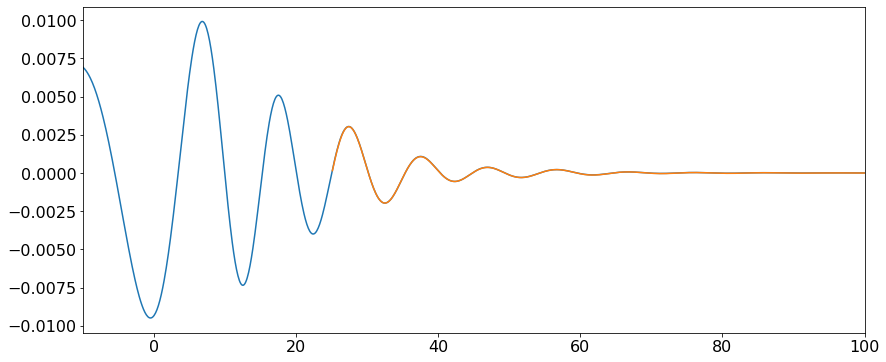

In [796]:
plt.figure(figsize=(14,6))
plt.plot(x, y_im)
plt.plot(x_fit, yhat_im)
plt.xlim(-10, 100)

In [797]:
y_ = y + 1.j*y_im
yhat_ = yhat_re + 1.j*yhat_im

(-10.0, 100.0)

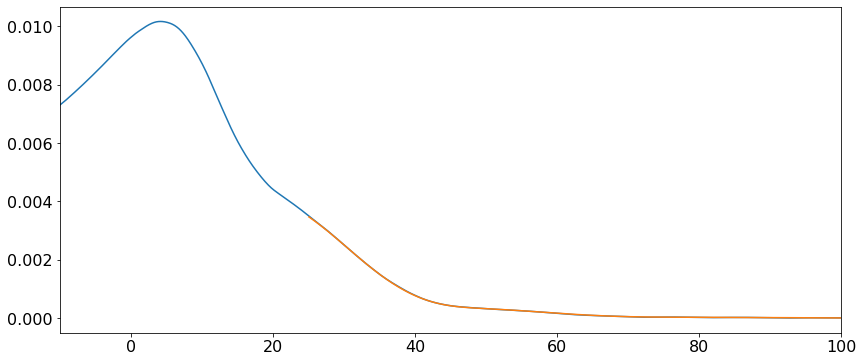

In [798]:
plt.figure(figsize=(14,6))
plt.plot(x, np.abs(y_))
plt.plot(x[mask_fit], np.abs(yhat_))
plt.xlim(-10, 100)

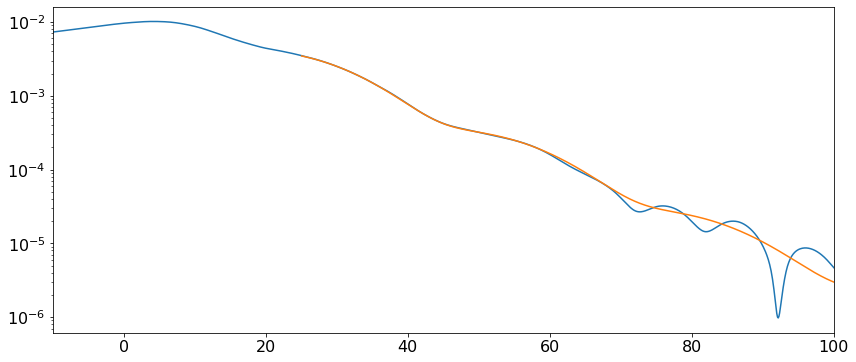

In [799]:
plt.figure(figsize=(14,6))
plt.plot(x, np.abs(y_))
plt.plot(x[mask_fit], np.abs(yhat_))
plt.xlim(-10, 100)
plt.yscale('log')

# fit around the peak

In [830]:
# x = nrls[2,2].times
# y = np.abs(nrls[2,2].strain)

x = nrls[3,2].times
y = np.abs(nrls[3,2].strain)


# x = nrls[4,4].times
# y = np.abs(nrls[4,4].strain)

# x = nrls[5,4].times
# y = np.abs(nrls[5,4].strain)

# x = nrls[5,5].times
# y = np.abs(nrls[5,5].strain)



x_start = -10
x_end = 25
mask_fit = (x >= x_start) & (x <= x_end)

x_fit = x[mask_fit]
y_fit = y[mask_fit]

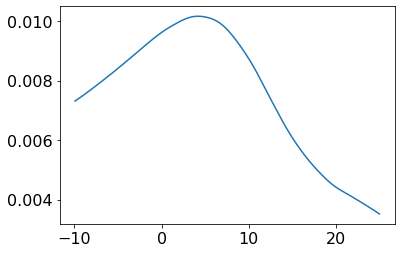

In [831]:
plt.plot(x_fit, y_fit)

In [832]:
# def f(x, x0, w, a, b, c, d, e):
#     t0 = a*np.ones_like(x)
#     t1 = b*np.arcsinh((x-x0)/w)**1
#     t2 = c*np.arcsinh((x-x0)/w)**2
#     t3 = d*np.arcsinh((x-x0)/w)**3
#     t4 = e*np.arcsinh((x-x0)/w)**4
#     terms = [t0, t1, t2, t3, t4]
#     return np.sum(terms, axis=0)

def sech(x):
    return 1/np.cosh(x)

# def f(x, x0, w, a, b, c, d):
#     t0 = a*np.ones_like(x)
#     t1 = b*sech((x-x0)/w)**1
#     t2 = c*sech((x-x0)/w)**2
#     t3 = d*sech((x-x0)/w)**3
#     terms = [t0, t1, t2, t3]
#     return np.sum(terms, axis=0)

# def f(x, x0, w, a, b, c, d, e):
#     t0 = a*np.ones_like(x)
#     t1 = b*np.tanh((x-x0)/w)**1
#     t2 = c*np.tanh((x-x0)/w)**2
#     t3 = d*np.tanh((x-x0)/w)**3
#     t4 = e*np.tanh((x-x0)/w)**4
#     terms = [t0, t1, t2, t3, t4]
#     return np.sum(terms, axis=0)

def f(x, x0, w, a, b, c, d, e):
    t0 = a*np.ones_like(x)
    t1 = b*np.tanh((x-x0)/w)**1
    t2 = c*np.tanh((x-x0)/w)**2
    t3 = d*np.cosh((x-x0)/w)**1
    t4 = e*np.cosh((x-x0)/w)**2
    terms = [t0, t1, t2, t3, t4]
    return np.sum(terms, axis=0)

def f(x, x0, x1, x2, a0, a1, a2, b0, b1, b2):
    # gaussian
    t0 = a0 * np.exp(-(x-x0)**2/b0)
    t1 = a1 * np.exp(-(x-x1)**2/b1)
    t2 = a2 * np.exp(-(x-x2)**2/b2)
    # cauchy
    # t0 = a0 * 1 / (1 + (x-x0)**2/b0)
    # t1 = a1 * 1 / (1 + (x-x1)**2/b1)
    # t2 = a2 * 1 / (1 + (x-x2)**2/b2)
    return t0 + t1 + t2


In [833]:
popt, pcov = scipy.optimize.curve_fit(f, x_fit, y_fit, maxfev=1000000)

In [834]:
popt

array([ 8.50334826e+00,  1.51456433e+01, -1.12280613e+00,  3.39652318e-03,
       -2.07359901e-03,  7.73106780e-03,  1.28308313e+02,  5.67742041e+01,
        8.56422619e+02])

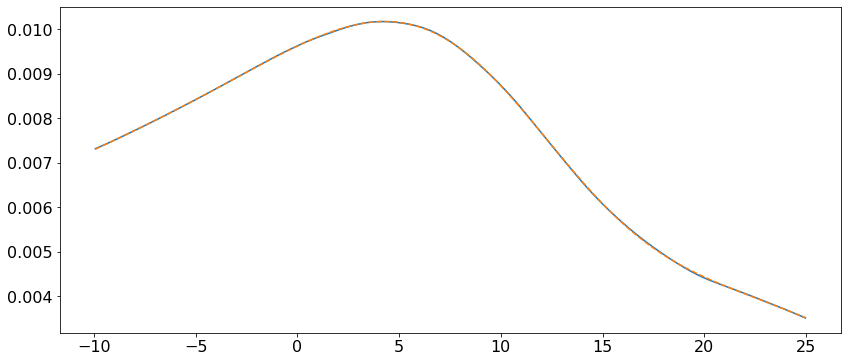

In [835]:
plt.figure(figsize=(14,6))
plt.plot(x_fit, y_fit)
plt.plot(x_fit, f(x_fit, *popt), ls='--')